# Week 6 Day 1: Vectorization

## Objectives:

* Become comfortable with arrays > 1D
* Work on avoiding loops (even nested ones)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Vectorized calculations

We will rather loosely be using the term "vectorized" to mean array-at-a-time computations.
True (hardware-level) vectorization actually runs a small set of multiple calculations at the same time on your device - this may or may not happen in our array computations - and it isn't important at the moment.

In [2]:
a = np.array([1, 2, 3, 4])
b = np.array([5, 6, 7, 8])

# Classic loops:
c1 = np.empty_like(a)
for i in range(len(a)):
    c1[i] = a[i] + b[i]

# Array-at-a-time, or "vectorized":
c2 = a + b

In [3]:
print(c1)
print(c2)

[ 6  8 10 12]
[ 6  8 10 12]


Let's try in two diminsions:

Note: since I'm explicitly looking at the output values, I'm okay to use square matricies. It's often a nice check to use non-square matricies if you have the choice; it catches missmatches in diminsions!

In [4]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])

# Classic loops:
c1 = np.empty_like(a)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        c1[i, j] = a[i, j] + b[i, j]

# Array-at-a-time, or "vectorized":
c2 = a + b

print(c1)
print(c2)

[[ 6  8]
 [10 12]]
[[ 6  8]
 [10 12]]


### Broadcasting reminder:

We've seen 1D broadcasting quite a bit: scalars can be mixed with arrays:

In [5]:
np.array([1, 2]) + 1

array([2, 3])

That expands to multiple diminsions like this:

```
(a, b, ..., z) OP (a, b, ..., z) -> element wise
(a, b, ..., z) OP (a, 1, ..., z) -> length 1 instead of b -> duplicated b times
(a, b, ..., z) OP (b, ..., z) -> prepend a diminsion of length 1 -> see above
```

The third rule explains scalars, but is a bit problematic. Try to use the second rule when possible instead.

In [6]:
print(np.ones([2, 3]) + np.ones([2, 3]))
print(np.ones([2, 3]) + np.ones([1, 3]))
print(np.ones([2, 3]) + np.ones([3]))

[[2. 2. 2.]
 [2. 2. 2.]]
[[2. 2. 2.]
 [2. 2. 2.]]
[[2. 2. 2.]
 [2. 2. 2.]]


## Memory layout

Computer memory is linear. It might be fragmented a bit, but it is not 2D or 3D. (and if it was, it would be even harder to manage). So, all objects more than 1D have to be laid out in some fasion. There are three choices for 2D arrays:
* Pointers to 1D arrays. Requires look ups to traverse - bad for performance and memory.
* Row major C order. Default in Python. Similar to the way we write.
* Column major F order (from Fortran). Default in Matlab, optional in Python.

Law: whenever there are two ways to do something, it will always be done both ways.


In [7]:
A = np.array([[1, 2], [3, 4]], order="C")
print(A)
print(A.flatten("K"))

[[1 2]
 [3 4]]
[1 2 3 4]


In [8]:
A = np.array([[1, 2], [3, 4]], order="F")
print(A)
print(A.flatten("K"))

[[1 2]
 [3 4]]
[1 3 2 4]


This matters when we make loops - how do we want the computer to look up the items in the list?

In [9]:
A = np.array([[1, 2], [3, 4]])

print("Continious:", end=" ")
for i in range(2):
    print(A[0, i], end=" ")

print()
print("Not continious:", end=" ")
for i in range(2):
    print(A[i, 0], end=" ")

Continious: 1 2 
Not continious: 1 3 

Numpy hides the details whenever it can. Even if you use Fortran style arrays, everything will still "just work"; unless you try hard, even "flatten" works the same way - it turns it into a C style flat array even if that's not how it's laid out in memory (add "K" to fix). Any method or function that depends on the order will have an `order=` argument. UFuncts will loop in the best order automatically. And Transposes are basically no-ops - they just change from C style to F style and vise versa!

In [10]:
print(np.isfortran(A))
print(np.isfortran(A.T))

False
True


Note: we'll discuss why `A.T` is the transpose of a matrix in a minute.

### Questions:
* Why is `np.ones([1,3]).reshape([2])` not allowed?
* Why is `np.ones([3]).reshape([1,3])` a no op?

In [11]:
np.ones([3]).flatten("K")

array([1., 1., 1.])

Adding a 1 length dimension is basically a "no-op" - the memory of the array does not change, just the interpretation of it.

So why is the auto up-scaling broadcasting (rule 3 above) irritating to use?

Given these two brodcasting expressions:

$$
\left[
\begin{matrix}
1 & 2 \\
3 & 4
\end{matrix}
\right]
\times
\left[
\begin{matrix}
1 & 2
\end{matrix}
\right]
$$

$$
\left[
\begin{matrix}
1 & 2 \\
3 & 4
\end{matrix}
\right]
\times
\left[
\begin{matrix}
1 \\
2
\end{matrix}
\right]
$$

What happens if the second one is just a 1D array?

In [12]:
a = np.array([[1, 2], [3, 4]])

print(a * np.array([[1, 2]]))
print(a * np.array([[1], [2]]))

print(a * np.array([1, 2]))

[[1 4]
 [3 8]]
[[1 2]
 [6 8]]
[[1 4]
 [3 8]]


In [13]:
A = np.array([[1, 2], [3, 4]])
A.T

array([[1, 3],
       [2, 4]])

## Aside:

Python objects (since Python 2.2, at least) provide **properties** - those are methods that look at at like members!

So the following:

```python
value = object.member
```

can secretly call a function! (Think `object.member()`, though it's technically calling `object.member.__get__()`.) A similar trick exists for setting, as well.

Why would you use them?

* You can turn a real member into a property as your class gets more complex
* You can avoid some `()` (great for chaining)
* You can take advantage of the nice set syntax

When would you use them?

* Not for long calculations - a user does not expect a program to hang when accessing or setting a member
* Only for simple properties that do not have *any* options

You can access the transpose of a matrix:

In [14]:
a.T

array([[1, 3],
       [2, 4]])

Since a 1D transpose does nothing, the following expression does not do what you might naively expect:

In [15]:
# print(a * np.array([1,2]).T)

The solution? Make this an explicit row or column vector. Generally, when doing linear algebra, you should be using 2D arrays. This does *not* mean that Python is wrong for having 1D arrays - it just adds flexibility.

Quick way to make a column vector:

In [16]:
print(np.array([[1, 2]]).T)

[[1]
 [2]]


Interesting note: The transpose actually just converts an array between C ordering and F ordering!

In [17]:
A.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [18]:
A.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

# Vectorization (array computing) with 2D arrays

It can be a little tricky to vectorize code, but the speed is worth it, and it can be easier to read in some cases. Let's take an example:

We have points in 3D space with a weight W. What is the weighted mean?

In [19]:
state = np.random.RandomState(42)
x = state.rand(10)
y = state.rand(10)
z = state.rand(10)
w = state.rand(10)

In [20]:
xsum = 0
ysum = 0
zsum = 0
wsum = 0

for i in range(len(x)):
    xsum += x[i] * w[i]
    ysum += y[i] * w[i]
    zsum += z[i] * w[i]
    wsum += w[i]

xsum /= wsum
ysum /= wsum
zsum /= wsum

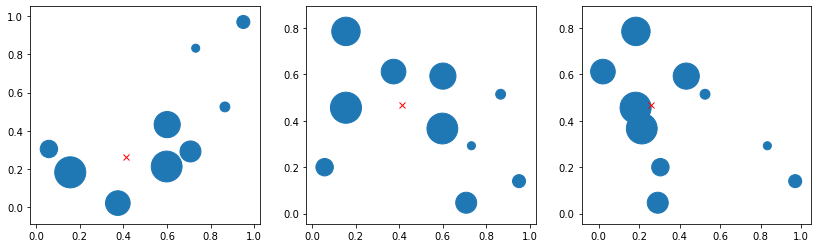

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].scatter(x, y, s=w * 1000)
axs[0].plot(xsum, ysum, "rx")
axs[1].scatter(x, z, s=w * 1000)
axs[1].plot(xsum, zsum, "rx")
axs[2].scatter(y, z, s=w * 1000)
axs[2].plot(ysum, zsum, "rx")
plt.show()

In [22]:
# state = np.random.RandomState(42)
# M = state.rand(4, 10)
M = np.stack([x, y, z])

In [23]:
M.shape

(3, 10)

In [24]:
Wsum = np.sum(w)
Msum = np.sum(M * w, axis=1) / Wsum
Msum.shape

(3,)

In [25]:
print(Msum == np.array([xsum, ysum, zsum]))

[ True  True  True]


### Question: Why is this true?

In [26]:
M1 = np.stack([x, y, z, w])
state = np.random.RandomState(42)
M2 = state.rand(4, 10)

print(M1 == M2)

[[ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]]


We can also do this with a 4x10 array.

In [27]:
Wsum2 = np.sum(M2[3])
Msum2 = np.sum(M2[:3] * M2[3], axis=1) / Wsum
Msum2.shape
Msum2 == np.array([xsum, ysum, zsum])

array([ True,  True,  True])

This (as we've seen) is nicer to generate, and keeps our number of variables down, but has the issue that it becomes less clear to read. We can use one of two tricks:

* Set `w = M2[3]` and `M=[:3]`. These will still be the same memory space (no copy is made - they are just "views"), so this does not come at a penalty.
* Use a record array, or Pandas. We'll cover this (Pandas, at least) later. If the types of the columns do not match, this is the only way to do it.